# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]

y_df = student_data['passed']
n_passed = y_df[y_df=='yes'].shape[0]
n_failed = n_students - n_passed
grad_rate = 100.0 * n_passed / n_students
    
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
%%capture 
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]           # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]              # feature values for all students
y_all = student_data[target_col]                # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()                              # print the first 5 rows

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):

    # output dataframe, initially empty
    outX = pd.DataFrame(index=X.index)

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int
        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
# X_all = pd.get_dummies(X_all)

print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [6]:
from sklearn.cross_validation import train_test_split
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 340                  # about 85% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=42)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 340 samples
Test set: 55 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [7]:
# Train a model
import time
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score


def train_classifier(clf, X_train, y_train):
    print "\nTraining {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    duration = end - start
    print "Training time (secs): {:.3f}".format(duration)
    return duration

def predict_labels(clf, features, target):
    # print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Prediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

def train_predict(clf, X_train, y_train, X_test, y_test):
    print "----------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    train_f1_score = predict_labels(clf, X_train, y_train)
    test_f1_score = predict_labels(clf, X_test, y_test)
    print "F1 score for training set: {}".format(train_f1_score)
    print "F1 score for test set: {}".format(test_f1_score)    
    return train_f1_score, test_f1_score


# TODO: Choose a model, import it and instantiate an object
# TODO: Run the helper function above for desired subsets of training data

clfs = [DecisionTreeClassifier(random_state=42),
        LogisticRegression(random_state=42),
        SVC(random_state=42)]

for clf in clfs:
    print "============================================="
    
    # Fit model to training data
    train_classifier(clf, X_train, y_train)  # note: using entire training set here

    # Predict on training & testing set and compute F1 score
    train_f1_score = predict_labels(clf, X_train, y_train)
    test_f1_score = predict_labels(clf, X_test, y_test)
    print "F1 score for training set: {}".format(train_f1_score)
    print "F1 score for test set: {}".format(test_f1_score)
    
    for idx, train_size in enumerate([100, 200, 300]):
        X_train_temp = X_train.iloc[:train_size]
        y_train_temp = y_train.iloc[:train_size]
        train_predict(clf, X_train_temp, y_train_temp, X_test, y_test)

print "=============================================" 



Training DecisionTreeClassifier...
Training time (secs): 0.003
F1 score for training set: 1.0
F1 score for test set: 0.693333333333
----------
Training set size: 100

Training DecisionTreeClassifier...
Training time (secs): 0.001
F1 score for training set: 1.0
F1 score for test set: 0.675675675676
----------
Training set size: 200

Training DecisionTreeClassifier...
Training time (secs): 0.001
F1 score for training set: 1.0
F1 score for test set: 0.8
----------
Training set size: 300

Training DecisionTreeClassifier...
Training time (secs): 0.002
F1 score for training set: 1.0
F1 score for test set: 0.657534246575

Training LogisticRegression...
Training time (secs): 0.003
F1 score for training set: 0.842315369261
F1 score for test set: 0.80487804878
----------
Training set size: 100

Training LogisticRegression...
Training time (secs): 0.001
F1 score for training set: 0.872180451128
F1 score for test set: 0.769230769231
----------
Training set size: 200

Training LogisticRegression..

In [8]:
%%capture
# test the effect of training sample size on F1 score with a finer interval of 20 instead of 100
# the resutls are visualized in the next cell
# output in this cell is suppressed

train_f1_scores = []
test_f1_scores = []

for clf in clfs:
    print "=============================================" 
    # Fit model to training data
    # note: using entire training set here
    train_classifier(clf, X_train, y_train)  

    # Predict on training & testing set and compute F1 score
    train_f1_score = predict_labels(clf, X_train, y_train)
    test_f1_score = predict_labels(clf, X_test, y_test)
    print "F1 score for training set: {}".format(train_f1_score)
    print "F1 score for test set: {}".format(test_f1_score)
    
    # Train and predict using different training set sizes
    train_sizes = np.arange(20, X_train.shape[0]+1, 20)
    train_f1_score = np.zeros(train_sizes.shape)
    test_f1_score = np.zeros(train_sizes.shape)
    
    for idx, train_size in enumerate(train_sizes):
        X_train_temp = X_train.iloc[:train_size]
        y_train_temp = y_train.iloc[:train_size]
        train_f1_score[idx], test_f1_score[idx] = train_predict(clf, X_train_temp, y_train_temp, X_test, y_test)
    
    # Collect f1 scores for each classifier     
    train_f1_scores.append(train_f1_score)
    test_f1_scores.append(test_f1_score)    
        
print "=============================================" 

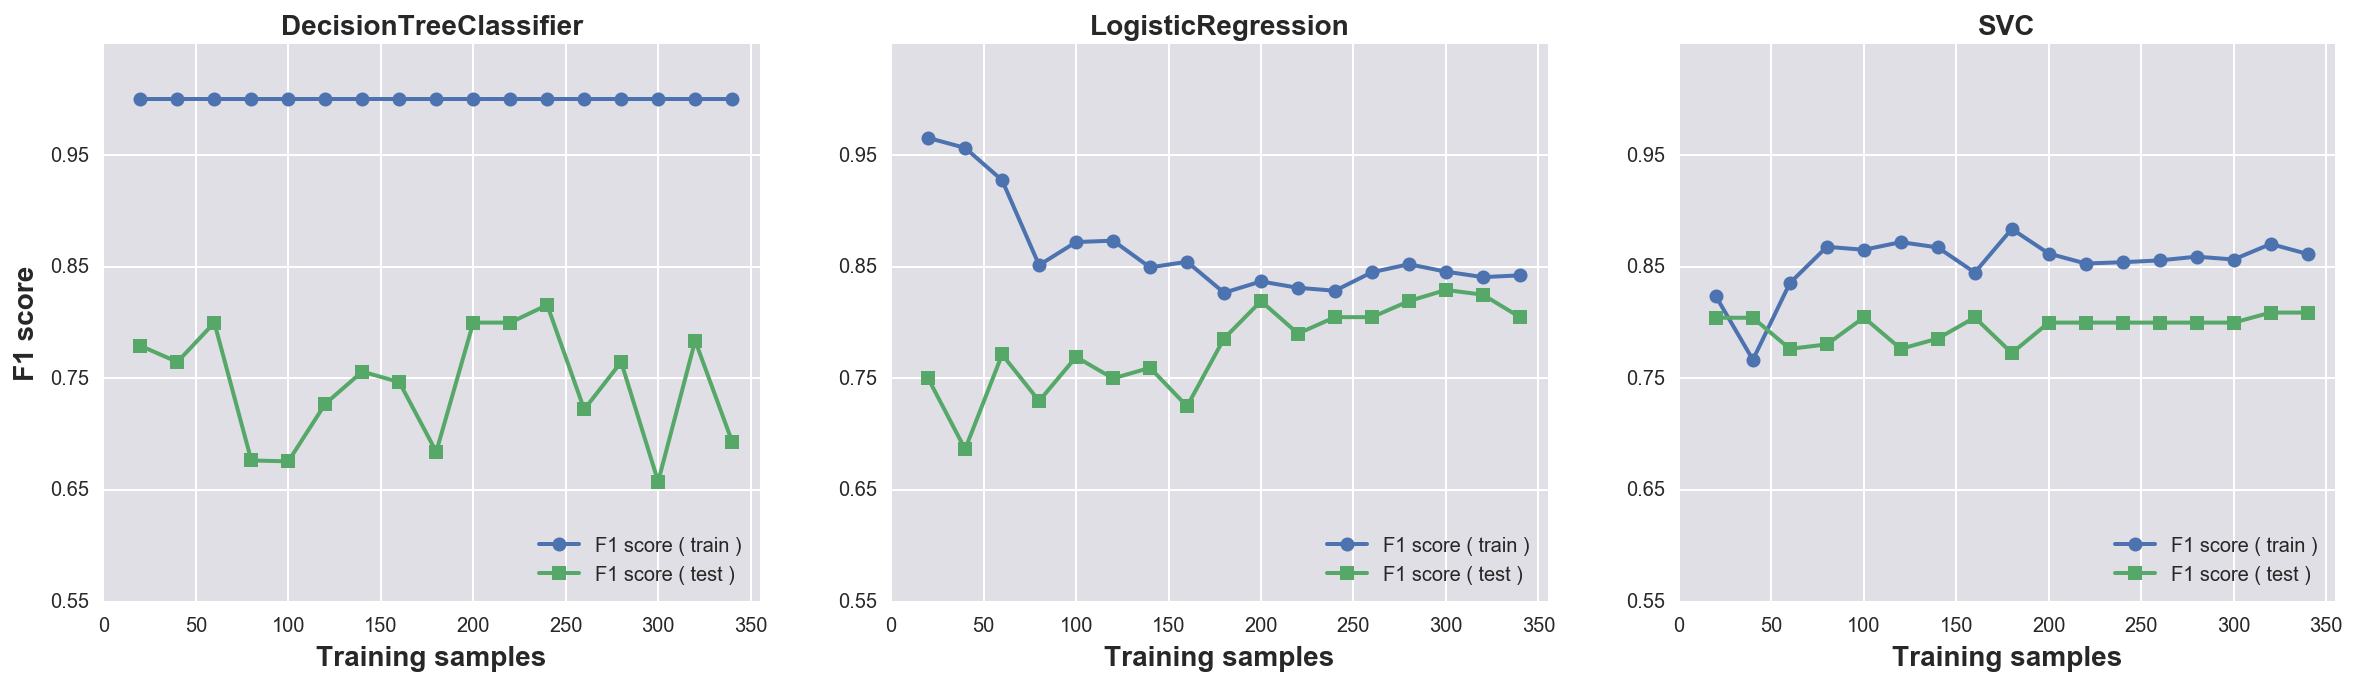

In [9]:
# visualize F1 score vs training sample size
# seaborn settings from [http://bebi103.caltech.edu/2015/tutorials/t0b_intro_to_jupyter_notebooks.html]

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 14, 
      'axes.titlesize': 14, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

plt.figure(1, figsize=(20, 5), dpi=300)
idx_subplot = 1
for idx, clf in enumerate(clfs):
    
    # each subplot corresponds to a classifier    
    plt.subplot(1, len(clfs),idx_subplot)
    plt.plot(train_sizes, train_f1_scores[idx], marker='o', label='F1 score ( train )')
    plt.plot(train_sizes, test_f1_scores[idx], marker='s', label='F1 score ( test )')

    if idx_subplot == 1: plt.ylabel('F1 score', fontweight='bold')
    plt.xlabel('Training samples', fontweight='bold')
    plt.title('%s' % clf.__class__.__name__, fontweight='bold')
    plt.xlim(0, X_train.shape[0]+15)
    plt.ylim(0.55, 1.05)
    plt.yticks(np.arange(0.55, 1.05, 0.1))
    plt.legend(loc='lower right')

    idx_subplot += 1

plt.savefig('./F1_vs_training_size.pdf')

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [10]:
%%capture
# Takes around 7.2 mins to run on a 2.2 Ghz, 4-core machine

# TODO: Fine-tune your model and report the best F1 score
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# time the script
start = time.time()

# calc_scores (f1_score, accuracy_score, recall_score, precision_score)
def calc_scores(y, y_pred):
    return (f1_score       (y, y_pred),
            accuracy_score (y, y_pred),
            recall_score   (y, y_pred),
            precision_score(y, y_pred))

# import data
student_data = pd.read_csv("student-data.csv")

# extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])
target_col   = student_data.columns[-1]
le_y         = LabelEncoder()

X_all = pd.get_dummies(student_data[feature_cols])
y_all = student_data[target_col]
y_all = le_y.fit_transform(y_all)

# initialize classifiers for evaluations of performance
clfs_set = [AdaBoostClassifier(),
            DecisionTreeClassifier(),
            LogisticRegression(),
            SVC(),
            SGDClassifier(),
            RandomForestClassifier()]

clfs_best    = []
train_scores = []
test_scores  = []

# building param_grids for GridSearchCV
ada_grid = {'algorithm': ['SAMME', 'SAMME.R'],
            'n_estimators': np.linspace(1, 6, num=5).astype(int),
            'learning_rate': (0.001, 0.01, 0.1, 1, 10)}

dt_grid = {'criterion': ['gini', 'entropy'],
           'max_features': ['auto', 'sqrt', 'log2'],
           'max_depth': np.linspace(1, 10, num=10),
           'min_samples_split': np.linspace(2, 10, 1),
           'min_samples_leaf': (1, 2, 3, 4, 5)}

lr_grid = {'C': np.linspace(0.01, 0.2, num=200),
           'penalty': ['l1', 'l2']}

svc_grid = {'kernel': ['rbf', 'poly'],
            'gamma': np.linspace(0.01, 1, num=100)}

sgd_grid = {'loss': ['squared_hinge', 'hinge'],
            'penalty': ['l2', 'l1'],
            'alpha': np.linspace(0.001, 0.01, num=100)}

rf_grid = {'n_estimators': (10, 11, 12, 13, 14, 15, 16),
           'max_features': ['auto'],
           'criterion': ['gini', 'entropy'],
           'max_depth': (3, 4, 5, 6),
           'min_samples_split': (2, 3, 4, 5, 6)}

param_grids = [ada_grid, dt_grid, lr_grid, svc_grid, sgd_grid, rf_grid]

# run GridSearchCV for each classifier
num_runs   = 25
num_clfs   = len(clfs_set)
num_scores = 4
train_size = 0.80

for num_run in np.arange(num_runs):

    # randomize train_split for each run     
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=train_size)
    
    print('===============================================================================')
    print('Run #%d' % (num_run+1))
    for clf, param_grid in zip(clfs_set, param_grids):
        print("%s" % clf.__class__.__name__)

        clf_opt = GridSearchCV(estimator=clf,
                               param_grid=param_grid,
                               n_jobs=-1)
        clf_opt.fit(X_train, y_train)
        
        y_train_pred = clf_opt.predict(X_train)
        y_test_pred  = clf_opt.predict(X_test)
        
        # collect the bset estimator for each run
        clfs_best.append(clf_opt.best_estimator_)

        # calculate performance scores     
        train_scores.append(calc_scores(y_train, y_train_pred))
        test_scores.append (calc_scores(y_test,  y_test_pred))

        print('Training set: F1 score %.3f | Accuracy %.3f | Recall %.3f | Precision %.3f '
              % calc_scores(y_train, y_train_pred))

        print('Training set: F1 score %.3f | Accuracy %.3f | Recall %.3f | Precision %.3f\n '
              % calc_scores(y_test, y_test_pred))
print('===============================================================================')

train_scores = np.array(train_scores).reshape(num_runs, num_clfs, num_scores)
test_scores  = np.array(test_scores ).reshape(num_runs, num_clfs, num_scores)

# time the script
end = time.time()


In [11]:
print('\nTime elapsed: %.3f mins' % ((end-start)/60))


Time elapsed: 6.998 mins


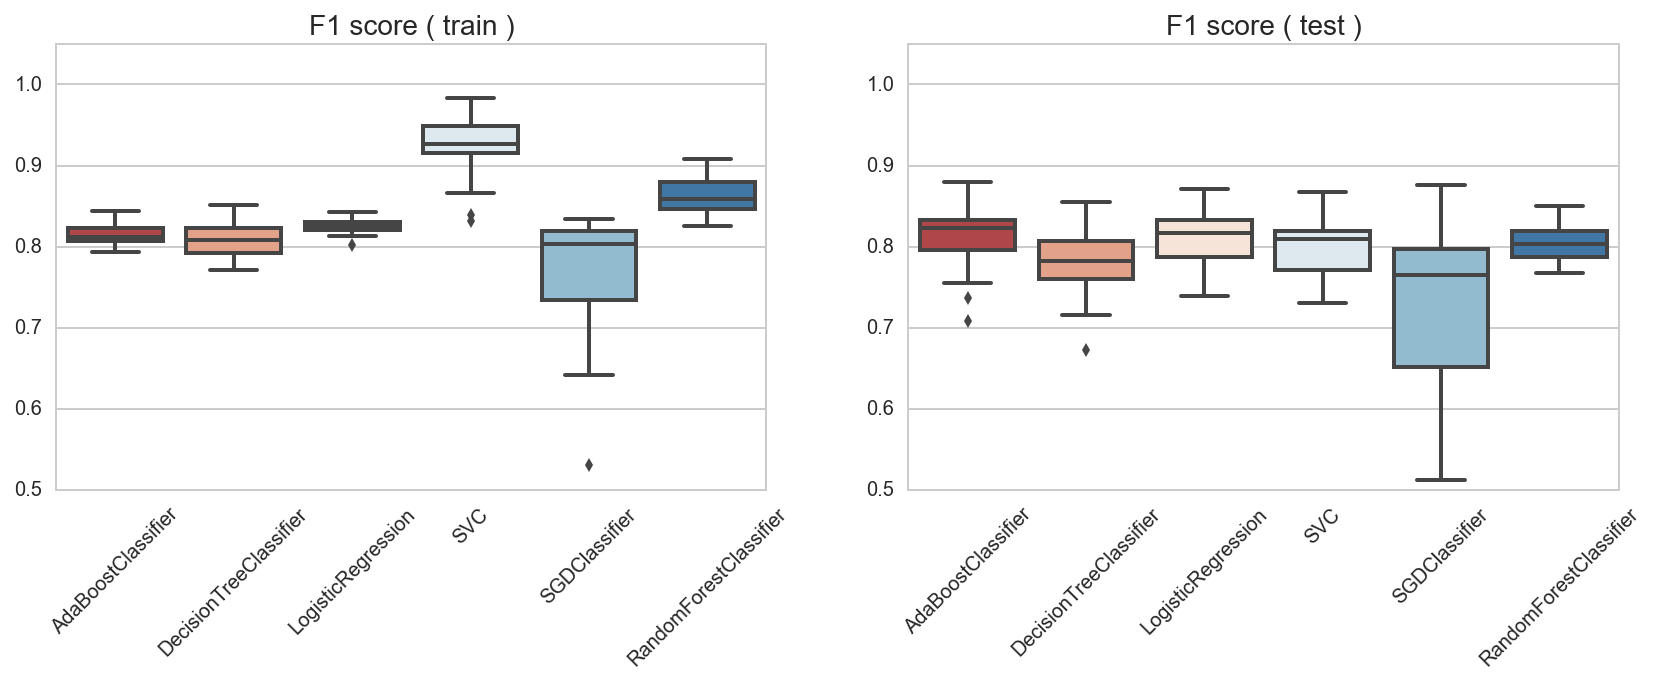

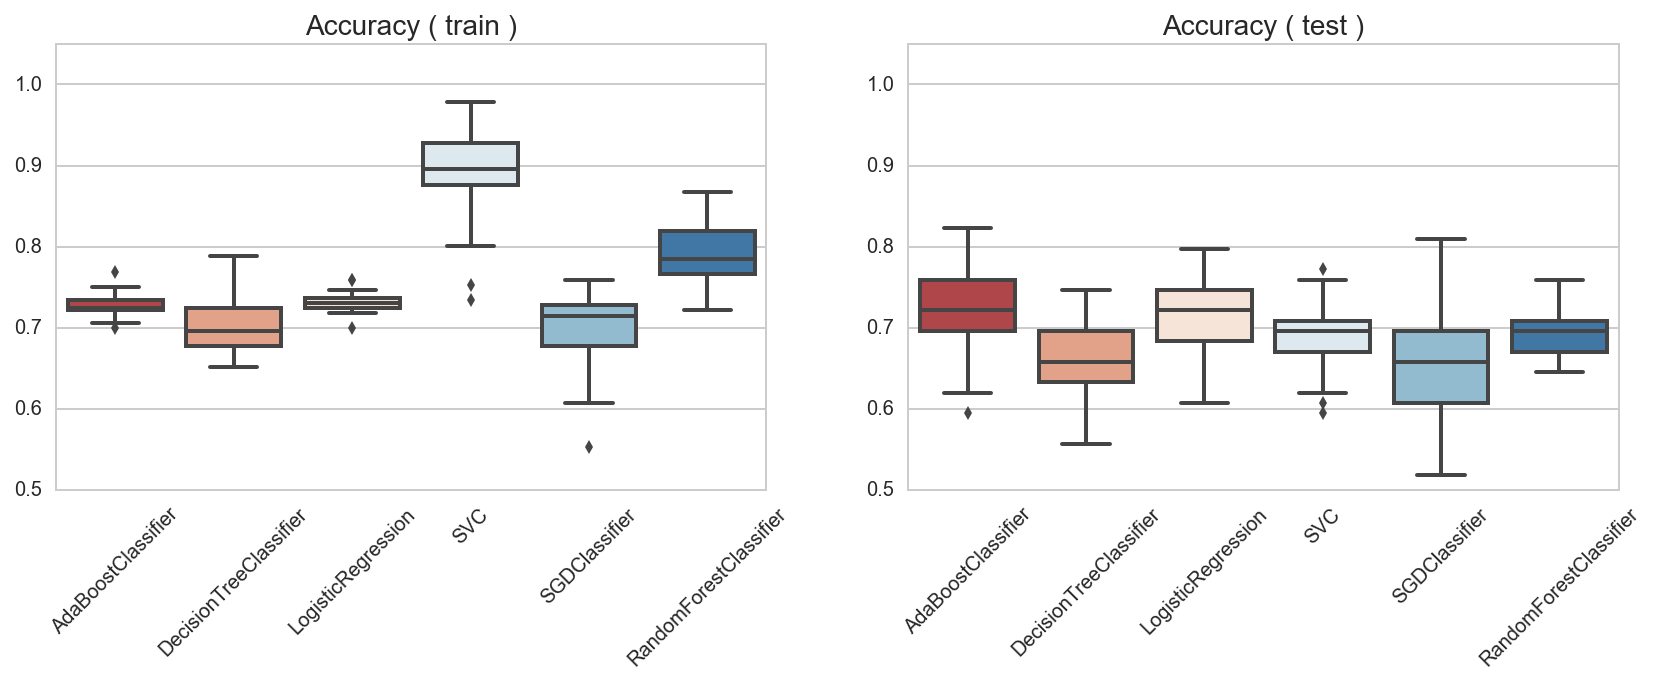

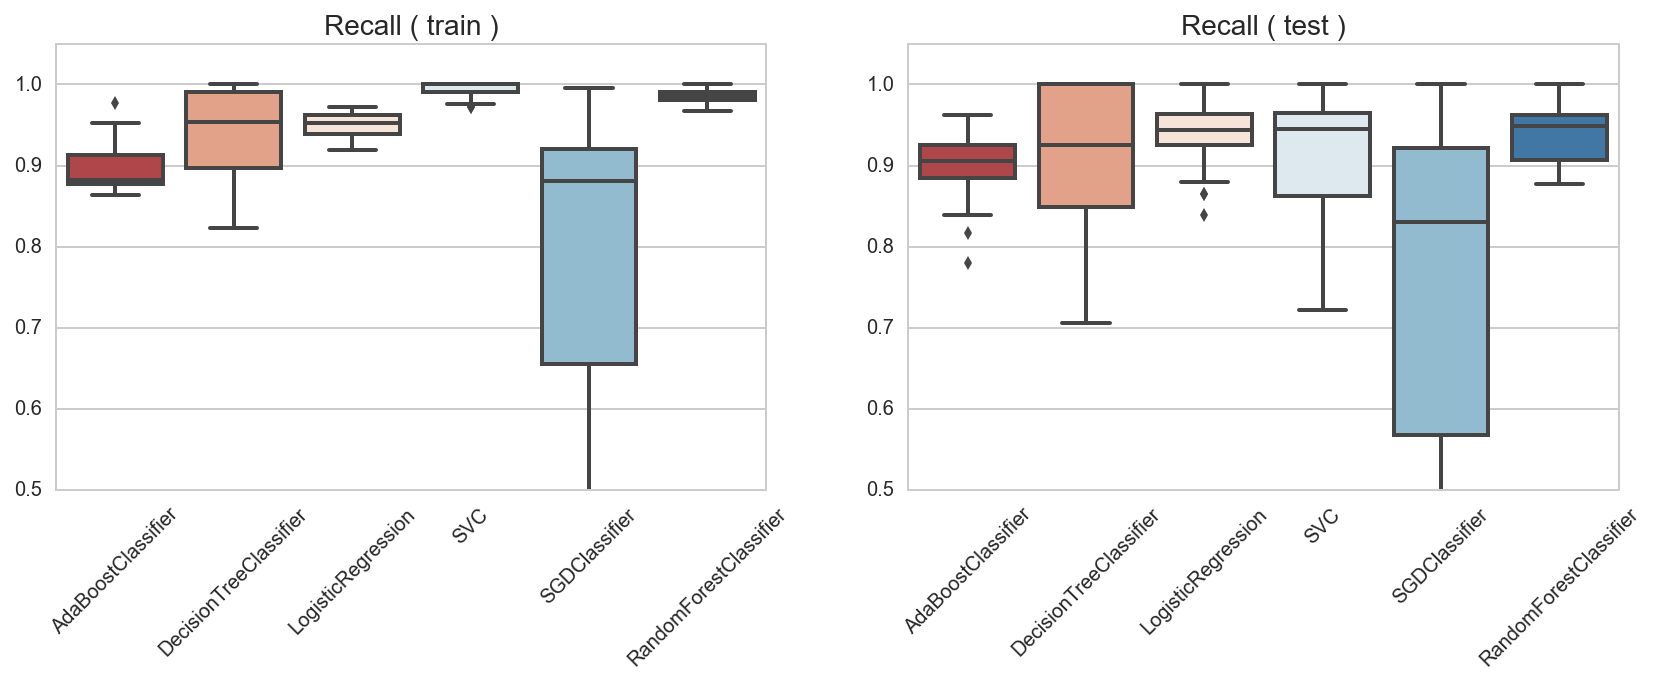

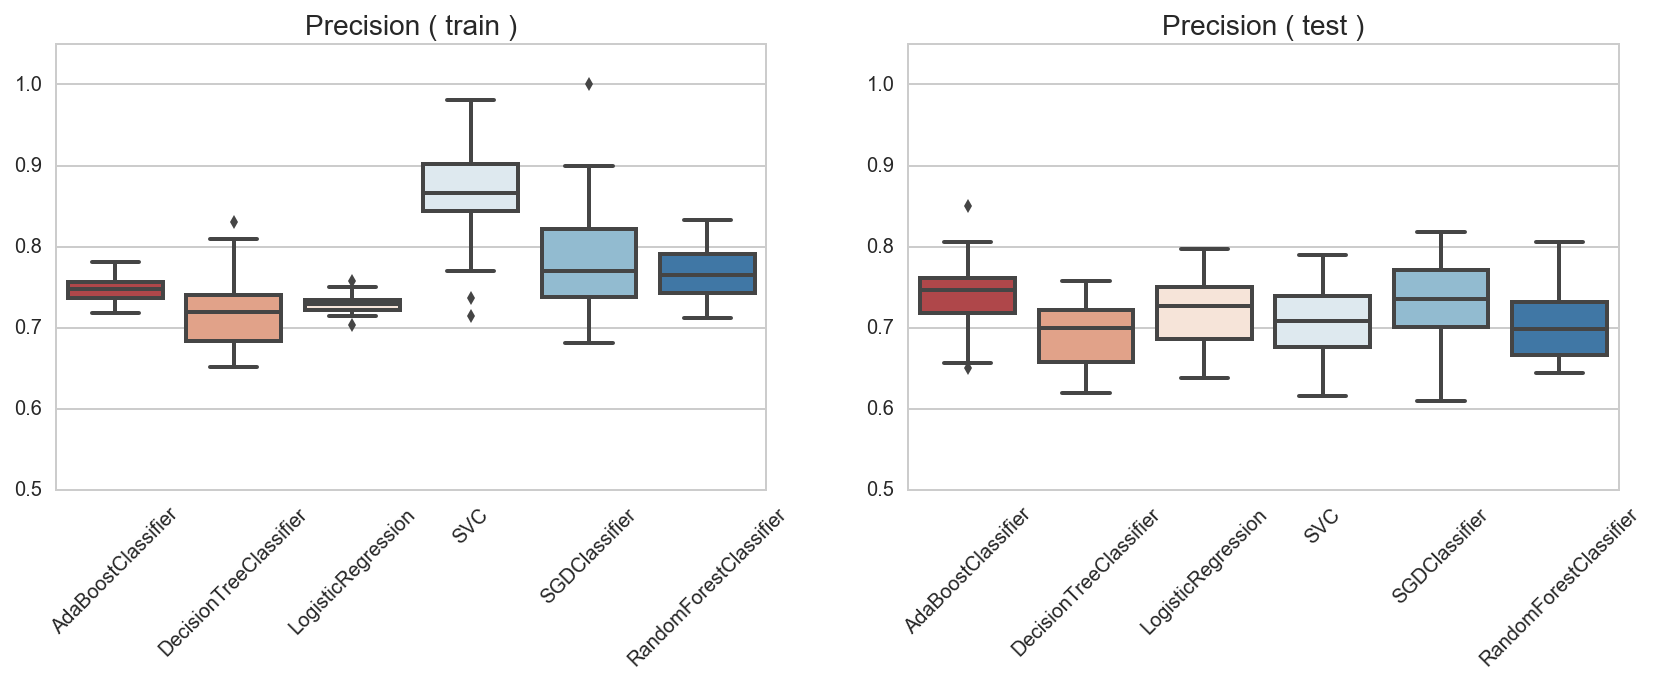

In [12]:
# box plots of ['F1 score', 'Accuracy', 'Recall', 'Precision'] for both training and testing set

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

score_labels = ['F1 score', 'Accuracy', 'Recall', 'Precision']
clf_labels   = [s.__class__.__name__ for s in clfs_set]

for idx_score, score_label in enumerate(score_labels):
    plt.figure(figsize=[14, 4])
    plt.subplot(1, 2, 1)
    ax = sns.boxplot(data=train_scores [:,:,idx_score], palette="RdBu")
    ax.set_ylim(0.5, 1.05)
    ax.set_xticklabels(())
    ax.set_title(score_label+' ( train )')
    plt.xticks(np.arange(num_clfs), clf_labels, rotation='45')  
        
    plt.subplot(1, 2, 2)
    ax = sns.boxplot(data=test_scores [:,:,idx_score], palette="RdBu")
    ax.set_ylim(0.5, 1.05)
    ax.set_xticklabels(())
    ax.set_title(score_label+' ( test )')
    plt.xticks(np.arange(num_clfs), clf_labels, rotation='45')  


In [13]:
# print statistics
for idx_score, score_label in enumerate(score_labels):
    print('=====================================================================')
    print(score_label)
    print(pd.DataFrame(train_scores[:, :, idx_score], columns=clf_labels).describe().T[['count', 'mean', 'std', 'min', 'max']])
    print(pd.DataFrame(test_scores [:, :, idx_score], columns=clf_labels).describe().T[['count', 'mean', 'std', 'min', 'max']])
print('=====================================================================')

F1 score
                        count      mean       std       min       max
AdaBoostClassifier       25.0  0.814669  0.011510  0.793926  0.843683
DecisionTreeClassifier   25.0  0.808787  0.020680  0.771300  0.851441
LogisticRegression       25.0  0.825401  0.008605  0.801670  0.842975
SVC                      25.0  0.922679  0.039784  0.832000  0.983452
SGDClassifier            25.0  0.744018  0.163166  0.046083  0.834061
RandomForestClassifier   25.0  0.864099  0.022618  0.825397  0.908696
                        count      mean       std       min       max
AdaBoostClassifier       25.0  0.812694  0.037150  0.709091  0.879310
DecisionTreeClassifier   25.0  0.781347  0.044451  0.672897  0.855072
LogisticRegression       25.0  0.813223  0.032350  0.739496  0.870968
SVC                      25.0  0.799018  0.038879  0.730435  0.867647
SGDClassifier            25.0  0.707789  0.173608  0.000000  0.876033
RandomForestClassifier   25.0  0.806881  0.023515  0.767857  0.850394
Accuracy
  

In [14]:
print('Best F1 score:\n')
print(pd.DataFrame(train_scores[:, :, 0], columns=clf_labels).describe().T['max'])
print('')
print(pd.DataFrame(test_scores [:, :, 0], columns=clf_labels).describe().T['max'])

Best F1 score:

AdaBoostClassifier        0.843683
DecisionTreeClassifier    0.851441
LogisticRegression        0.842975
SVC                       0.983452
SGDClassifier             0.834061
RandomForestClassifier    0.908696
Name: max, dtype: float64

AdaBoostClassifier        0.879310
DecisionTreeClassifier    0.855072
LogisticRegression        0.870968
SVC                       0.867647
SGDClassifier             0.876033
RandomForestClassifier    0.850394
Name: max, dtype: float64
